# Cyber Bully Tweet Classifier

In [2]:
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
#from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('cyberbullying_tweets.csv')
display(df.sample(5))
df.shape

,tweet_text,cyberbullying_type
27033,RT @arhourigan: @freebsdgirl @Spacekatgal I im...,other_cyberbullying
43833,"Oh ? You mad ? “@tayyoung_: FUCK OBAMA, dumb a...",ethnicity
2205,"@PurplePotency dammit! Smh. Wellllll , i think...",not_cyberbullying
12034,@chiakimagica RAPE JOKES AND GAY JOKES YEAH,gender
22350,@AbbsWinston @andyblueskyz In Palestine a woma...,religion


(47692, 2)

In [5]:
df['cyberbullying_type'].unique()


array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [6]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

@TuckMyJPP YOU CAN BE A NIGGER LOVER ALL YOU WANT BUT KEEP YOUR DISGUSTING BLACK FRIENDS FROM TALKING TO ME YOU MARIACHI BAND BITCH.

I disagree with your reading of it. Why would there be racism in a meeting where their necks or on the line? I understand it to mean that from the discussion, they couldn't pick up that there wasn't any during the incident.

«@_iShotBarbie_ Lmao tell her again RT @MzParkaMzParkuh: That's PRESIDENT nigga to you.. RT @tayyoung_: FUCK OBAMA, dumb ass nigger»

Eating. Literally. When I met all of my cousins significant others for the very first time they all said so ur “Dania, the one who loves food” or whenever I meet my parents they say this as well

RT @YesYoureRacist @ReDidi I'm not sexist or racist.... Okay maybe only when I'm driving.



In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [8]:
df.describe()


,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [9]:
df.isnull().sum()


tweet_text            0
cyberbullying_type    0
dtype: int64

In [10]:
df['tweet_text'].duplicated().sum()


1675

In [11]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)
df['tweet_text'].duplicated().sum()

0

In [12]:
df['cyberbullying_type'].value_counts()


cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [13]:
df = df[df["cyberbullying_type"] != "other_cyberbullying"]
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity'],
      dtype=object)

In [14]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)
df.sample(5)

,tweet_text,cyberbullying_type
35509,I remember I was bullied heaps bc of how small...,3
42654,"imagine cuddling to ur bf's chest, tonight &am...",4
39631,She mad ? RT @Iam_keylolo: Lmfao RT @Blowindat...,4
18048,@IlhanMN @Ilhan you truly are an idiot anybody...,2
18710,You mean how country folk want nothing to do w...,2


In [15]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()    # Using Lemmatizer instead of Stemmer

In [21]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)
    
def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words) 

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res
def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res


In [22]:
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [23]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
341,@Palle_Hoffstein @CranBoonitz FreeBSD keeps ge...,0,freebsd keep getting email firing well yknow o...
16848,4. Interesting that you use the phrase of Hind...,2,4 interesting use phrase hindutwa bloodlust wa...
6117,@ThorsProvoni @NafeezAhmed @MaxBlumenthal @Num...,0,ah point show anti semite thanks
11409,People have body shamed him and people have ma...,1,people body shamed people made rape joke even ...
34552,Like middle school girls who got together hatc...,3,like middle school girl got together hatched p...


In [24]:
!pip install tweet-preprocessor
import preprocessor as p

In [25]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

In [26]:
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [27]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
39857,@CamrenPhel Proving me right. Bitch who can't ...,4,proving right bitch cant spell ya stupid fuck ...
37348,I hope everyone has a great day today except f...,3,hope everyone great day today except girl one ...
2494,"@ummayman90 Richard II is nobody's prophet, mi...",0,richard ii nobody prophet microbrain cant excu...
10545,"and it’s like, okay, we get it. you hate black...",1,like okay get hate black people gay people wom...
18400,She is disrespectful! You are in Jordan! You m...,2,disrespectful jordan may musli muslim woman th...


In [28]:
df['clean_tweets'].duplicated().sum()


1217

In [29]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [30]:
df.shape


(38557, 3)

In [31]:
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count
15986,Guys IM SCREAMING. I almost died. I was eating...,2,guy screaming almost died eating popcorn liste...,48
14779,"RT @bloody_osiris: Dear Wifey ,I hate that ano...",1,dear wifey hate another bitch kan say,14
26662,It's interesting to me that not everyone up he...,3,interesting everyone like think low self estee...,47
26232,In this school we say no to bullies! (Except f...,3,school say bully except bullying principal guy...,18
14527,Too bad they won't take you! @the_CRISPY_man C...,1,bad wont take call sexist want ill take woman ...,27


In [32]:
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
22460,I am not muslim idiot. Why don't you take the ...,2,muslim idiot dont take half kashmir war invade...,36,4.22
20890,Those with ak47 are always killed. Army won't ...,2,ak47 always killed army wont worship terrorist...,38,5.34
37986,"Fuck you dumb bitch ass niggers, and fuck you ...",4,fuck dumb bitch as nigger fuck twitter whipped...,41,4.22
19566,Learn something from ur past idiots. Don’t for...,2,learn something past idiot dont forget hindust...,41,4.54
13005,"@AMohedin Okay, we have women being physically...",1,okay woman physically inferior either emotiona...,18,5.50


In [33]:
df = df[df['word_count']>3]
df = df[df['word_count']<100]
df.reset_index(drop=True, inplace=True)
df.shape

(38201, 5)

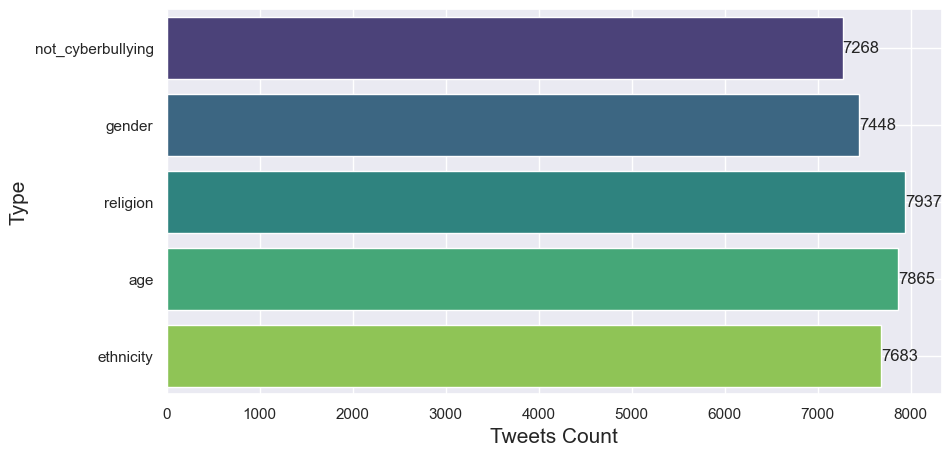

In [34]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

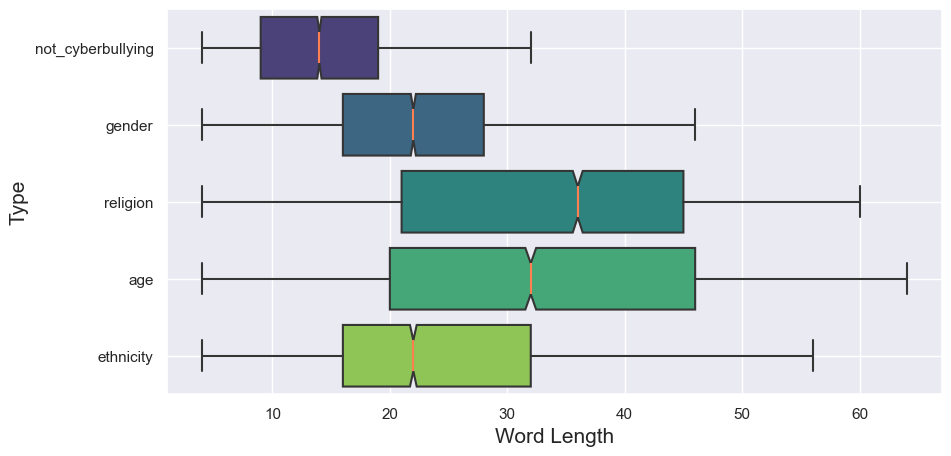

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

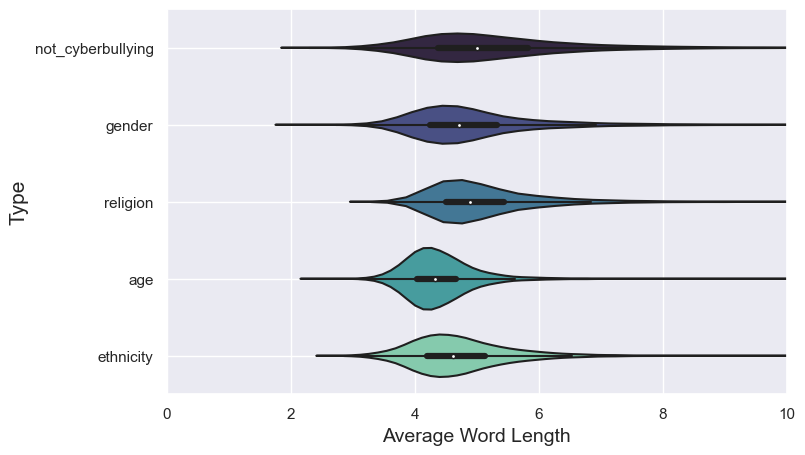

In [36]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Text(34.875, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

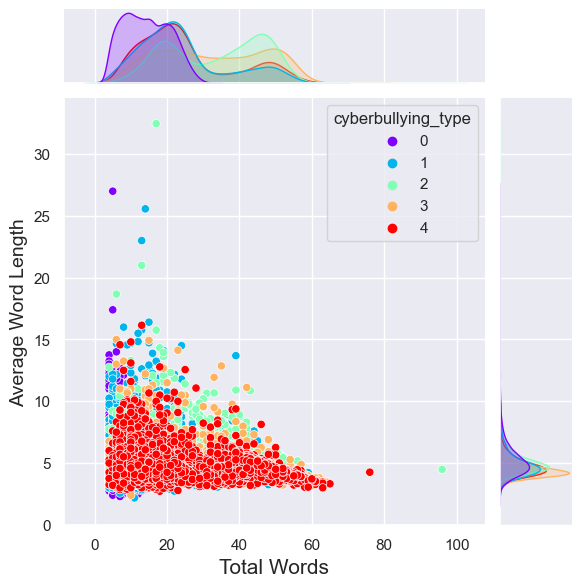

In [37]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

In [38]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 38438
[('word', 867), ('food', 128), ('crapilicious', 1), ('white', 2213), ('classy', 29)]


In [39]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

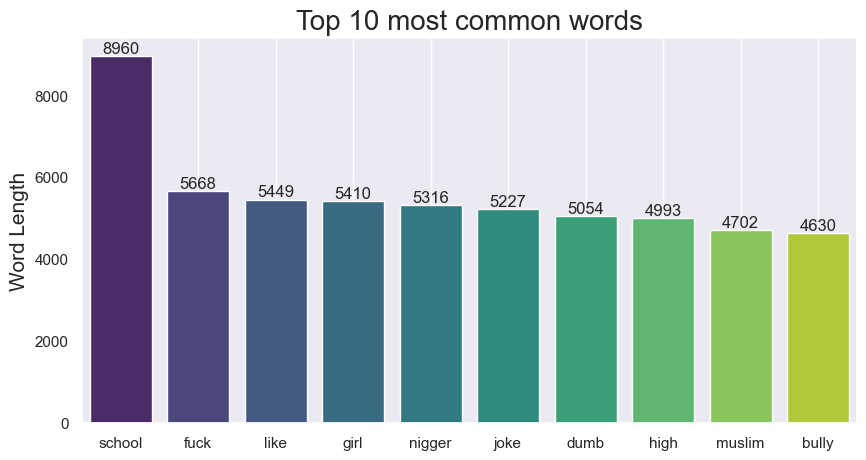

In [40]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [41]:
X = df['clean_tweets']
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

In [42]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)    # Fit on train
print("No. of feature words:", len(tfidf.get_feature_names_out()))

No. of feature words: 291885


In [43]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)
print(f"{X_train_tf.shape = }\n{X_test_tf.shape = }")

X_train_tf.shape = (30560, 291885)
X_test_tf.shape = (7641, 291885)


In [44]:
# Model training
lr = LogisticRegression(solver='saga', penalty='l2', random_state=394)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=394, solver='saga')

In [45]:
y_pred_train = lr.predict(X_train_tf)
y_pred_test = lr.predict(X_test_tf)

In [46]:
print('\tClassification Report for Logistic Regression on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Logistic Regression on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Logistic Regression on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.95      0.91      5814
           gender       0.98      0.91      0.94      5958
         religion       0.98      0.98      0.98      6350
              age       0.98      0.99      0.98      6292
        ethnicity       0.99      0.99      0.99      6146

         accuracy                           0.96     30560
        macro avg       0.96      0.96      0.96     30560
     weighted avg       0.96      0.96      0.96     30560


	Classification Report for Logistic Regression on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.81      0.79      0.80      1454
           gender       0.93      0.85      0.89      1490
         religion       0.95      0.96      0.95      1587
              age       0.92      0.99      0.95      1573
        ethnicity       0.96      0.99      0.97      

Text(0.5, 1.0, 'Confusion Matrix LR')

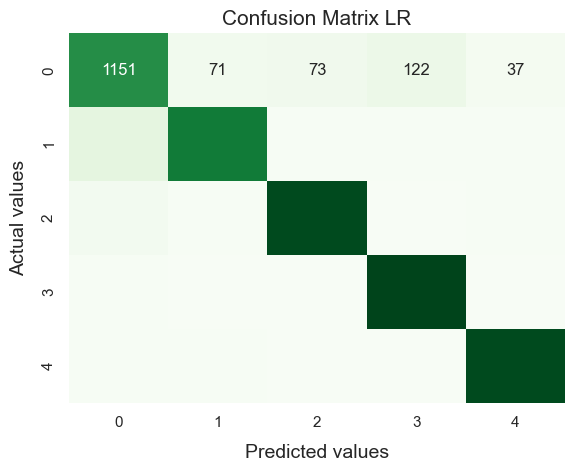

In [47]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix LR', size=15)

In [48]:
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train_tf, y_train)

MultinomialNB(alpha=0.1)

In [49]:
y_pred_train = mnb.predict(X_train_tf)
y_pred_test = mnb.predict(X_test_tf)

In [50]:
print('\tClassification Report for Naive-Bayes\' on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Naive-Bayes\' on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Naive-Bayes' on Train

                    precision    recall  f1-score   support

not_cyberbullying       1.00      0.97      0.99      5814
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      0.99      6292
        ethnicity       0.99      1.00      1.00      6146

         accuracy                           0.99     30560
        macro avg       0.99      0.99      0.99     30560
     weighted avg       0.99      0.99      0.99     30560


	Classification Report for Naive-Bayes' on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.48      0.62      1454
           gender       0.87      0.84      0.86      1490
         religion       0.84      0.97      0.90      1587
              age       0.79      0.98      0.88      1573
        ethnicity       0.88      0.94      0.91      1537

        

Text(0.5, 1.0, 'Confusion Matrix NB')

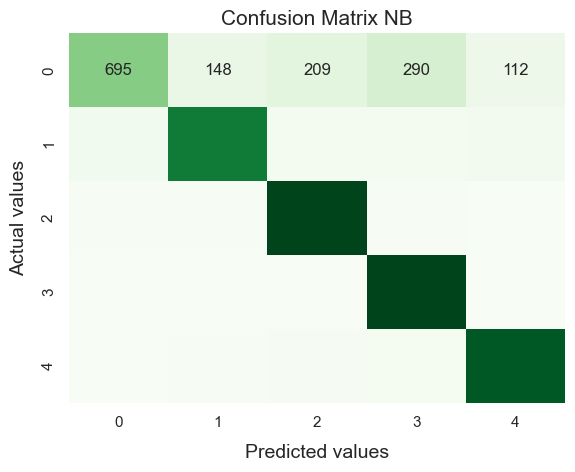

In [51]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix NB', size=15)